# UMAP
## A Functional Introduction

### Uniform Manifold Approximation and Projection (UMAP) 
is a dimension reduction
technique that can be used for visualisation similarly to t-SNE, but also for
general non-linear dimension reduction. The algorithm is founded on three
assumptions about the data

1. The data is uniformly distributed on Riemannian manifold;
2. The Riemannian metric is locally constant (or can be approximated as such);
3. The manifold is locally connected (not globally, but locally).

From these assumptions it is possible to model the manifold with a fuzzy
topological structure. The embedding is found by searching for a low dimensional
projection of the data that has the closest possible equivalent fuzzy
topological structure.




### A Simple Task
Lets just run umap on a common dataset, using the UMAP defaults

('Original Data Shape: ', (1797, 64))
CPU times: user 2.06 s, sys: 588 ms, total: 2.65 s
Wall time: 1.9 s
('Embedded Data Shape: ', (1797, 2))


<IPython.core.display.Javascript object>


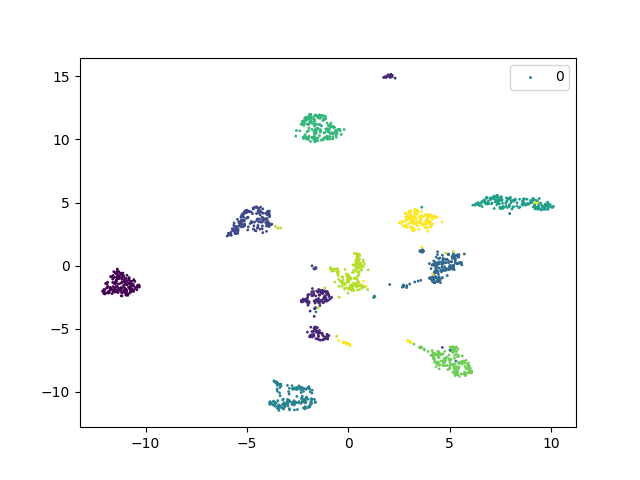

In [11]:
# Grab what we need via imports
import umap
from sklearn.datasets import load_digits
import numpy as np
import matplotlib.pyplot as plt
%matplotlib nbagg

# Load in the digit dataset, and take a look at its shape
digits = load_digits()
print("Original Data Shape: ", digits.data.shape)
labels = digits.target



%time embedding = umap.UMAP(n_components=2).fit_transform(digits.data)

print("Embedded Data Shape: ", embedding.shape)

colors = labels/10.

# Make a simple scatter plot
plt.scatter(embedding[:,0], embedding[:,1], c= colors, s=1)
plt.legend(labels)
plt.show()

Ok I like that, but I don't like the difficulty I have in figuring out what point belongs to which number
Lets take advantage of bokeh's plotting abilities 


In [14]:
# Bokeh imports
import bokeh.plotting as bk
bk.output_notebook()
from bokeh.io import output_notebook, show, push_notebook
from bokeh.plotting import figure
from bokeh.models import HoverTool, ColumnDataSource
output_notebook()

# Build a color map
def mapNumToC(c):
        
    mini = float(min(c))
    maxi = float(max(c))
    print mini, maxi
    colors = []
    for i in c:
        i = float(i)
        ratio = 2. * (i - mini) / (maxi-mini)
        b = int(max(0, 255*(1 - ratio)))
        r = int(max(0, 255*(ratio - 1)))
        g = 255 - b - r
        colors.append('#%02x%02x%02x' % (r,g,b))
    return colors


c = mapNumToC(colors)

source = ColumnDataSource(data=dict(
    x=embedding[:,0],
    y=embedding[:,1],
    value=labels,
    fill_color=c,
))

# color looks like color is misspelled. 

hover = HoverTool(tooltips=[
    ("Number", "@value")
])

p = figure(tools=[hover, 'reset,wheel_zoom,undo,redo,save,tap,pan'],
           title="Mouse over the dots")

p.circle('x', 'y', size=8, source=source, line_color=None, fill_color=c)

t = show(p)

Loading BokehJS ...

Loading BokehJS ...

0.0 0.9


/home/keith/anaconda2/lib/python2.7/site-packages/bokeh/util/deprecation.py:34: BokehDeprecationWarning: 
Supplying a user-defined data source AND iterable values to glyph methods is deprecated.

See https://github.com/bokeh/bokeh/issues/2056 for more information.

  warn(message)
